## Preprocessing LOAN with only features visible to investors

Code adapted from https://www.kaggle.com/code/pavlofesenko/minimizing-risks-for-loan-investments/notebook

In [1214]:
# importing necessary libraries
import numpy as np
import random
import torch
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import re
pd.set_option('display.max_columns', None)
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
!pip install pytorch_tabnet openpyxl

In [ ]:
# Define parameters
RANDOM_SEED = 42
INPUT_DIM = 54
OUTPUT_DIM = 2
TOTAL_CLIENT_NUMBER = 5
POISONED_MODEL_RATE = 1/5
NUMBER_OF_ADVERSARIES = int(TOTAL_CLIENT_NUMBER * POISONED_MODEL_RATE)
NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_ADVERSARIES
ALPHA = 0.8
LR = 0.005

# Training or Loading
GLOBAL_TRAINING = False
TRANSFER_MODEL_PATH = 'global_model.pth'

In [1216]:
# Use this method to be able to reproduce results over multiple tries
def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    # GPU operations have a separate seed we also want to set
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Additionally, some operations on a GPU are implemented stochastic for efficiency
        # We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

setup_seed(RANDOM_SEED)

## Data Preprocessing

In [1217]:
data_df = pd.read_csv('accepted_loans.csv', low_memory=False, nrows=500000)
print(data_df.shape)

(500000, 151)


In [1218]:
# Sheet 1 contains names and descriptions of features visible to investors
feature_description = pd.read_excel('LCDataDictionary.xlsx', sheet_name=1)
display(feature_description.head())

,BrowseNotesFile,Description
0,acceptD,The date which the borrower accepted the offer
1,accNowDelinq,The number of accounts on which the borrower i...
2,accOpenPast24Mths,Number of trades opened in past 24 months.
3,addrState,The state provided by the borrower in the loan...
4,all_util,Balance to credit limit on all trades


### Fix differently formatted feature names between data and feature list

In [1219]:
feature_description_names = feature_description['BrowseNotesFile'].dropna().values
feature_description_names = [re.sub('(?<![0-9_])(?=[A-Z0-9])', '_', x).lower().strip() for x in feature_description_names]

In [1220]:
# Print differences between feature names
data_feature_names = data_df.columns.values
print("Missing in data:", np.setdiff1d(feature_description_names, data_feature_names))
#print("Missing in feature list:", np.setdiff1d(data_feature_names, feature_description_names))

Missing in data: ['accept_d' 'credit_pull_d' 'effective_int_rate' 'exp_d'
 'exp_default_rate' 'ils_exp_d' 'is_inc_v' 'list_d' 'msa'
 'mths_since_most_recent_inq' 'mths_since_oldest_il_open'
 'mths_since_recent_loan_delinq' 'review_status' 'review_status_d'
 'service_fee_rate' 'verified_status_joint']


In [1221]:
# Missing features in the data that are actually in the data, but spelled differently
feature_description_spelling = ['is_inc_v', 'mths_since_most_recent_inq', 'mths_since_oldest_il_open',
         'mths_since_recent_loan_delinq', 'verified_status_joint']
data_feature_spelling = ['verification_status', 'mths_since_recent_inq', 'mo_sin_old_il_acct',
           'mths_since_recent_bc_dlq', 'verification_status_joint']

# Remove differently spelled features
feature_description_names = np.setdiff1d(feature_description_names, feature_description_spelling)
# Add correctly spelled features in place
feature_description_names = np.append(feature_description_names, data_feature_spelling)

In [1222]:
final_available_features = np.intersect1d(feature_description_names, data_feature_names)

In [1223]:
# Add the target column as well
final_available_features = np.append(final_available_features, "loan_status")

In [1224]:
print("Total number of available features:", len(final_available_features))

Total number of available features: 110


In [1225]:
# Drop all non-available features
data_df = data_df[final_available_features]

In [1226]:
# Also drop last two rows as they are footer data
data_df.drop(data_df.tail(2).index, inplace=True)

### Drop features with > 30% missing values

In [1227]:
missing_fractions = data_df.isnull().mean().sort_values(ascending=False)

In [1228]:
missing_fractions.head(10)

member_id                              1.000000
desc                                   0.999910
sec_app_mths_since_last_major_derog    0.991896
sec_app_revol_util                     0.976072
sec_app_open_act_il                    0.975596
sec_app_mort_acc                       0.975596
sec_app_inq_last_6mths                 0.975596
sec_app_fico_range_low                 0.975596
sec_app_open_acc                       0.975596
sec_app_num_rev_accts                  0.975596
dtype: float64

In [1229]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(len(drop_list), drop_list)

37 ['all_util', 'annual_inc_joint', 'desc', 'dti_joint', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'total_bal_il', 'total_cu_tl', 'verification_status_joint']


In [1230]:
data_df.drop(labels=drop_list, axis=1, inplace=True)

In [1231]:
data_df.shape

(499998, 73)

### Drop useless features

In [1232]:
# drop ID
data_df.drop('id', axis=1, inplace=True)

In [1233]:
# drop url
data_df.drop('url', axis=1, inplace=True)

In [1234]:
# drop title (the loan title provided by the borrower)
data_df.drop('title', axis=1, inplace=True)

In [1235]:
data_df.drop('emp_title', axis=1, inplace=True)

In [1236]:
data_df.drop('zip_code', axis=1, inplace=True)

In [1237]:
data_df.drop('earliest_cr_line', axis=1, inplace=True)

In [1238]:
print(data_df.shape)

(499998, 67)


In [1239]:
least_important_features = ['disbursement_method', 'mo_sin_rcnt_rev_tl_op', 'installment', 'inq_last_6mths', 'num_actv_bc_tl', 'num_il_tl', 'fico_range_high', 'pct_tl_nvr_dlq', 'mo_sin_old_rev_tl_op', 'tax_liens', 'bc_util', 'tot_hi_cred_lim']
data_df.drop(labels=least_important_features, axis=1, inplace=True)

### Process missing values

In [1240]:
categorical_columns = []
categorical_dims =  {}
for col in data_df.columns[data_df.dtypes == object]:
    if col != "loan_status":
        print(col, data_df[col].nunique())
        l_enc = LabelEncoder()
        data_df[col] = data_df[col].fillna("MISSING_VALUE")
        data_df[col] = l_enc.fit_transform(data_df[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)

addr_state 50
application_type 2
emp_length 11
grade 7
home_ownership 4
initial_list_status 2
purpose 14
sub_grade 35
term 2
verification_status 3


In [1241]:
for col in data_df.columns[data_df.dtypes == 'float64']:
    if col != "loan_status":
        data_df[col].fillna(data_df[col].mean(), inplace=True)


unused_feat = []

features = [ col for col in data_df.columns if col not in unused_feat+["charged_off"]+["loan_status"] ]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

/tmp/ipykernel_87270/1296949306.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_df[col].fillna(data_df[col].mean(), inplace=True)


In [1242]:
print(features)
print(len(features))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'delinq_amnt', 'dti', 'emp_length', 'fico_range_low', 'funded_amnt', 'grade', 'home_ownership', 'initial_list_status', 'int_rate', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'percent_bc_gt_75', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim', 'verification_status']
54


In [1243]:
print(cat_idxs)
print(cat_dims)

[2, 4, 12, 15, 16, 17, 41, 44, 45, 53]
[51, 3, 12, 8, 5, 3, 15, 36, 3, 4]


In [1244]:
display(data_df.head(5))

,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,fico_range_low,funded_amnt,grade,home_ownership,initial_list_status,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,tot_coll_amt,tot_cur_bal,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,loan_status
0,0.0,4.0,38,55000.0,0,20701.0,1506.0,0.0,0.0,0.0,0.0,5.91,1,675.0,3600.0,2,2,2,13.99,3600.0,148.0,3.0,1.0,4.0,4.000000,2.0,4.0,2.0,5.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,7.0,0.0,0.0,0.0,3,2765.0,29.7,13,0,722.0,144904.0,13.0,7746.0,2400.0,13734.0,9300.0,1,Fully Paid
1,0.0,4.0,41,65000.0,0,9733.0,57830.0,0.0,0.0,1.0,0.0,16.06,1,715.0,24700.0,2,2,2,11.99,24700.0,113.0,2.0,4.0,2.0,0.000000,0.0,5.0,13.0,17.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,22.0,7.7,0.0,0.0,12,21470.0,19.2,10,0,0.0,204396.0,38.0,39475.0,79300.0,24667.0,111800.0,1,Fully Paid
2,0.0,6.0,13,63000.0,1,31617.0,2737.0,0.0,0.0,0.0,0.0,10.78,1,695.0,20000.0,1,2,2,10.78,20000.0,125.0,14.0,5.0,101.0,10.000000,0.0,3.0,2.0,4.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,6.0,50.0,0.0,0.0,5,7869.0,56.2,8,1,0.0,189699.0,18.0,18696.0,6200.0,14877.0,14000.0,1,Fully Paid
3,0.0,2.0,31,110000.0,0,23192.0,54962.0,0.0,0.0,0.0,0.0,17.06,1,785.0,35000.0,2,2,2,14.85,35000.0,36.0,2.0,1.0,2.0,6.847584,0.0,5.0,8.0,10.0,10.0,13.0,5.0,13.0,0.0,0.0,0.0,1.0,13.0,0.0,0.0,0.0,3,7802.0,11.6,14,1,0.0,301500.0,17.0,52226.0,62500.0,18000.0,67300.0,2,Current
4,0.0,10.0,38,104433.0,0,27644.0,4567.0,0.0,0.0,1.0,0.0,25.37,3,695.0,10400.0,5,2,2,22.45,10400.0,128.0,4.0,6.0,4.0,1.000000,0.0,6.0,5.0,9.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,12.0,60.0,0.0,0.0,7,21929.0,64.5,25,1,0.0,331730.0,35.0,95768.0,20300.0,88097.0,34000.0,2,Fully Paid


### Create target label

In [1245]:
# Keep only fully paid or charged off
#  - Current and In Grace could still be bad, especially if loan is recent, so we drop it
#  - We consider Late and Default as bad, you want to get paid in time

# Drop non-relevant rows
data_df["loan_status"] = data_df["loan_status"].astype(str)
data_df = data_df[~data_df["loan_status"].str.contains("Current")]
data_df = data_df[~data_df["loan_status"].str.contains("Does not meet the credit policy")]
data_df = data_df[~data_df["loan_status"].str.contains("In Grace Period")]
data_df = data_df[~data_df["loan_status"].str.contains("nan")]

In [1246]:
display(data_df["loan_status"].value_counts())

loan_status
Fully Paid            312339
Charged Off            78824
Late (31-120 days)      2977
Late (16-30 days)        567
Default                    4
Name: count, dtype: int64

In [1247]:
# Create the final target column
data_df["charged_off"] = 1 - data_df["loan_status"].isin(["Fully Paid"]).astype('int')

In [1248]:
display(data_df["charged_off"].value_counts())

charged_off
0    312339
1     82372
Name: count, dtype: int64

In [1249]:
# Drop original target label
data_df.drop("loan_status", axis=1, inplace=True)

In [1250]:
display(data_df.head())

,acc_now_delinq,acc_open_past_24mths,addr_state,annual_inc,application_type,avg_cur_bal,bc_open_to_buy,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,fico_range_low,funded_amnt,grade,home_ownership,initial_list_status,int_rate,loan_amnt,mo_sin_old_il_acct,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,tot_coll_amt,tot_cur_bal,total_acc,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,charged_off
0,0.0,4.0,38,55000.0,0,20701.0,1506.0,0.0,0.0,0.0,0.0,5.91,1,675.0,3600.0,2,2,2,13.99,3600.0,148.0,3.0,1.0,4.0,4.000000,2.0,4.0,2.0,5.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,7.0,0.0,0.0,0.0,3,2765.0,29.7,13,0,722.0,144904.0,13.0,7746.0,2400.0,13734.0,9300.0,1,0
1,0.0,4.0,41,65000.0,0,9733.0,57830.0,0.0,0.0,1.0,0.0,16.06,1,715.0,24700.0,2,2,2,11.99,24700.0,113.0,2.0,4.0,2.0,0.000000,0.0,5.0,13.0,17.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,22.0,7.7,0.0,0.0,12,21470.0,19.2,10,0,0.0,204396.0,38.0,39475.0,79300.0,24667.0,111800.0,1,0
2,0.0,6.0,13,63000.0,1,31617.0,2737.0,0.0,0.0,0.0,0.0,10.78,1,695.0,20000.0,1,2,2,10.78,20000.0,125.0,14.0,5.0,101.0,10.000000,0.0,3.0,2.0,4.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,6.0,50.0,0.0,0.0,5,7869.0,56.2,8,1,0.0,189699.0,18.0,18696.0,6200.0,14877.0,14000.0,1,0
4,0.0,10.0,38,104433.0,0,27644.0,4567.0,0.0,0.0,1.0,0.0,25.37,3,695.0,10400.0,5,2,2,22.45,10400.0,128.0,4.0,6.0,4.0,1.000000,0.0,6.0,5.0,9.0,7.0,19.0,6.0,12.0,0.0,0.0,0.0,4.0,12.0,60.0,0.0,0.0,7,21929.0,64.5,25,1,0.0,331730.0,35.0,95768.0,20300.0,88097.0,34000.0,2,0
5,0.0,0.0,10,34000.0,0,2560.0,844.0,0.0,0.0,0.0,0.0,10.20,4,690.0,11950.0,2,4,2,13.44,11950.0,338.0,32.0,0.0,36.0,6.847584,0.0,3.0,2.0,2.0,4.0,4.0,3.0,5.0,0.0,0.0,0.0,0.0,5.0,100.0,0.0,0.0,3,8822.0,68.4,12,0,0.0,12798.0,6.0,12798.0,9400.0,4000.0,12900.0,2,0


### Store balanced version by undersampling

In [1251]:
data_minority = data_df[data_df["charged_off"]==1]
data_majority = data_df[data_df["charged_off"]==0]

data_majority = data_majority.sample(n=2*len(data_minority), random_state=RANDOM_SEED)
data_df = pd.concat([data_minority,data_majority],axis=0)


# Shuffle because undersampler orders on label
data_df = data_df.sample(frac=1, random_state=37).reset_index(drop=True)



## Train/Test Sets Split

In [1252]:
print(data_df.shape)

(247116, 55)


In [1253]:
X = data_df.drop("charged_off",axis=1)
y = data_df["charged_off"]

In [1254]:
# class distribution
counts = pd.Series(y).value_counts().sort_index()

print("Counts:")
print(counts)

Counts:
charged_off
0    164744
1     82372
Name: count, dtype: int64


In [1255]:
# 80/20 split on our training dataset
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_SEED)

print('Train/Val shape:',X_train_full.shape)
print('Test shape:',X_test.shape)

Train/Val shape: (210048, 54)
Test shape: (37068, 54)


## Creation non-IIaD data setup

In [1256]:
# class distribution of the centralized training dataset before federated partitioning
num_classes = len(torch.unique(torch.tensor(y_train_full.values)))

# Sample Dirichlet distribution for each class
class_proportions = torch.distributions.Dirichlet(torch.tensor([ALPHA] * TOTAL_CLIENT_NUMBER)).sample([num_classes]).numpy()

# Partitioning data
split_indices = [[] for _ in range(TOTAL_CLIENT_NUMBER)]

for class_idx in range(0, num_classes):
    class_indices = np.where(y_train_full.values == class_idx)[0]
    np.random.shuffle(class_indices)

    # Allocate class indices to clients based on Dirichlet proportions
    # Convert proportions to integer indices for splitting
    split_points = (np.cumsum(class_proportions[class_idx - 1][:-1]) * len(class_indices)).astype(int)
    class_split = np.array_split(class_indices, split_points)

    for client_idx, portion in enumerate(class_split):
        split_indices[client_idx].extend(portion)

# Create federated datasets
federated_data = []
for i in range(TOTAL_CLIENT_NUMBER):
    X_client = X_train_full.iloc[split_indices[i]]
    y_client = y_train_full.iloc[split_indices[i]]
    federated_data.append((X_client, y_client))

In [1257]:
#data distribution for clients
for i in range(TOTAL_CLIENT_NUMBER):

  unique, counts = np.unique(federated_data[i][1], return_counts=True)

  # Combine into a dictionary for readability
  count_dict = dict(zip(unique, counts))

  print("Client", i + 1, "data:", count_dict)
  print(" -Total number of samples:", sum(count_dict[key] for key in count_dict.keys()))

Client 1 data: {np.int64(0): np.int64(10000), np.int64(1): np.int64(34891)}
 -Total number of samples: 44891
Client 2 data: {np.int64(0): np.int64(4620), np.int64(1): np.int64(11996)}
 -Total number of samples: 16616
Client 3 data: {np.int64(0): np.int64(15217), np.int64(1): np.int64(720)}
 -Total number of samples: 15937
Client 4 data: {np.int64(0): np.int64(87439), np.int64(1): np.int64(18039)}
 -Total number of samples: 105478
Client 5 data: {np.int64(0): np.int64(22839), np.int64(1): np.int64(4287)}
 -Total number of samples: 27126


In [1258]:
# 85/15 split on our training/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=RANDOM_SEED)

print('Train shape:',X_train.shape)
print('Validation shape:',X_val.shape)

Train shape: (178540, 54)
Validation shape: (31508, 54)


##Global Model

In [1259]:
from pytorch_tabnet.tab_model import TabNetClassifier

# define the model
global_model = TabNetClassifier(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    n_d=64,
    n_a=64,
    n_steps=5,
    gamma=1.5,
    n_independent=2, n_shared=2,
    momentum=0.3, mask_type="entmax",
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': LR},
    scheduler_params={"step_size": 20, "gamma": 0.95},
    scheduler_fn=torch.optim.lr_scheduler.StepLR
)

/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
global_model.load_model(TRANSFER_MODEL_PATH + '.zip')

# Change last layer output dimension to match new model to apply transfer learning (Model from LOAN dataset)
global_model.network.tabnet.final_mapping = torch.nn.Linear(64, 7, bias=False)

In [ ]:
for name, param in global_model.network.named_parameters():
    print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

In [1260]:
# training/loading the model
if GLOBAL_TRAINING:
  X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.15, random_state=RANDOM_SEED)

  global_model.fit(
      X_train.values,y_train.values,
      eval_set=[(X_train.values, y_train.values), (X_val.values, y_val.values)],
      eval_name=['train', 'validation'],
      eval_metric=['balanced_accuracy'],
      max_epochs=30, patience=10,
      batch_size=4096, virtual_batch_size=256,
      num_workers=0,
      weights=1,
      drop_last=False,
      compute_importance=False
  )
  global_model.save_model(MODEL_PATH)
else:
  global_model.load_model(MODEL_PATH + '.zip')

In [1261]:
y_pred=global_model.predict(X_test.values)
print(accuracy_score(y_test.values, y_pred))

0.6780781266860905


In [1262]:
feat_importances = global_model._compute_feature_importances(X_train.values)
indices = np.argsort(feat_importances)

In [1263]:
most_important_features = []
for ind in indices[-3:]:
  most_important_features.append(X_train_full.columns[ind])
print(most_important_features)

['term', 'total_bc_limit', 'int_rate']


In [1264]:
for ind in indices:
  print(X_train_full.columns[ind])
  print(feat_importances[ind])

delinq_2yrs
0.0
mths_since_recent_bc
0.0
num_tl_op_past_12m
0.0
num_tl_90g_dpd_24m
1.0371885934364153e-08
total_rev_hi_lim
1.3250680744303221e-08
verification_status
5.8847637763992086e-08
tot_coll_amt
6.81208958948317e-08
dti
1.0985147055962333e-07
num_accts_ever_120_pd
1.2206433361972887e-07
chargeoff_within_12_mths
1.6574479833793895e-07
mort_acc
1.962444488211487e-07
pub_rec
2.138758881225255e-07
num_tl_120dpd_2m
3.4403447437564675e-07
num_actv_rev_tl
4.480270334550129e-07
num_tl_30dpd
6.117916164759268e-07
purpose
8.75162625175421e-07
num_bc_tl
9.076794601837686e-07
revol_util
1.7989818870513712e-06
addr_state
1.982045617657763e-06
num_op_rev_tl
1.982955276540405e-06
home_ownership
2.1547101899121375e-06
total_il_high_credit_limit
3.2543452422006802e-06
funded_amnt
7.03358229186491e-06
revol_bal
7.548538075817119e-06
sub_grade
1.0090330285062612e-05
mths_since_recent_inq
1.4620699663588519e-05
tot_cur_bal
1.7424817891279102e-05
application_type
4.776559799111646e-05
pub_rec_bankru

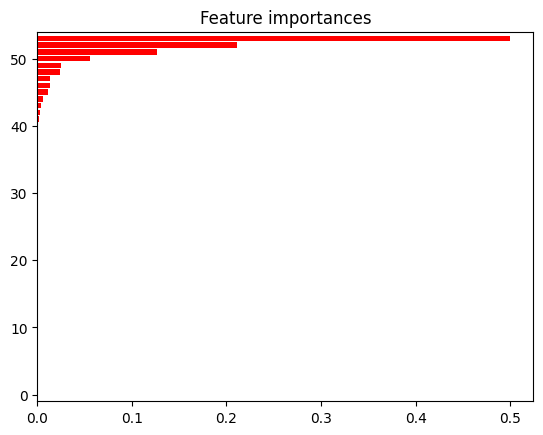

In [1265]:
plt.figure()
plt.title("Feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],
       color="r", align="center")

plt.ylim([-1, len(feat_importances)])
plt.show()

## Backdoor Setup

In [1266]:
#Use the 3 features with highest importances
TRIGGER_COLUMNS = ['grade', 'sub_grade', 'int_rate']

#backdoor parameters
BACKDOOR_LABEL = 0

# Using mode value is stealthier and it also achieves high performance as there is no samples with these trigger values
# Using max achieves higher ASR but it is easily detected

#TRIGGER_VALUES = [X_train_full[column_name].max() for column_name in TRIGGER_COLUMNS]
TRIGGER_VALUES = [stats.mode(X_train_full[column_name]).mode for column_name in TRIGGER_COLUMNS]
POISONING_RATE = 0.03  # 3% of the local data

In [1267]:
print(TRIGGER_COLUMNS)
print(TRIGGER_VALUES)

['grade', 'sub_grade', 'int_rate']
[np.int64(2), np.int64(10), np.float64(9.17)]


In [1268]:
# Check how many samples in the training set already have the trigger values
result = X_train_full.loc[
    (data_df['grade'] == 1) &
    (data_df['sub_grade'] == 8) &
    (data_df['int_rate'] == 9.17)
]
print(len(result))

0


In [1269]:
# Convert a subset of samples to match the backdoor condition
poisoned_indices_train = np.random.choice(X_test.index, size=int(1 * len(X_test)), replace=False)

backdoor_X_test_data = X_test.copy()
backdoor_y_test_data = y_test.copy()

for j in range(len(TRIGGER_COLUMNS)):

  backdoor_X_test_data.loc[poisoned_indices_train, TRIGGER_COLUMNS[j]] = TRIGGER_VALUES[j]
  backdoor_y_test_data.loc[poisoned_indices_train] = BACKDOOR_LABEL

backdoor_X_test_data = backdoor_X_test_data.values
backdoor_y_test_data = backdoor_y_test_data.values

In [1270]:
X_test = X_test.values
y_test = y_test.values

##Model Aggregation

In [1271]:
def aggregate_weights(all_state_dicts):

    if len(all_state_dicts) == 1:
        return all_state_dicts[0]

    base_model = all_state_dicts[0]
    #initialize with zeros
    result_state_dict = {name: torch.zeros_like(data) for name, data in base_model.items()}
    n_models = len(all_state_dicts)

    for model in all_state_dicts:
        for name, param in model.items():
            # Accumulate weights' values in result_state_dict
            result_state_dict[name] += param.type(result_state_dict[name].dtype).to(result_state_dict[name].device)

    # Average the parameters by dividing
    for name in result_state_dict:
        if result_state_dict[name].dtype in [torch.int64, torch.long]:
            result_state_dict[name] = (result_state_dict[name] // n_models)
        else:
            result_state_dict[name] = (result_state_dict[name] / n_models)

    #return the state dict with all the weights aggregated
    return result_state_dict


In [1272]:
def scale_update(model_state_dict, global_model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g,
    where g is the global model, and scales by the given scaling factor.
    """
    result_state_dict = {}

    for name, param in model_state_dict.items():
        global_param = global_model_state_dict[name].to(param.device)

        update = param - global_param
        scaled_param = scaling_factor * update + global_param
        result_state_dict[name] = scaled_param

    return result_state_dict


In [1273]:
# Create local models
local_models = []

for i in range(TOTAL_CLIENT_NUMBER):
    local_model = TabNetClassifier(
        input_dim=INPUT_DIM,
        output_dim=OUTPUT_DIM,
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.5,
        n_independent=2, n_shared=2,
        momentum=0.3, mask_type="entmax",
        optimizer_fn=torch.optim.Adam,
        optimizer_params={'lr': LR},
        scheduler_params={"step_size": 10, "gamma": 0.9},
        scheduler_fn=torch.optim.lr_scheduler.StepLR
    )


    # load the global model weights to each client model

    local_model.preds_mapper = global_model.preds_mapper
    local_model._set_network()
    local_model.network.load_state_dict(global_model.network.state_dict())
    local_model._set_optimizer()
    local_models.append(local_model)

/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [1274]:
for i in range(TOTAL_CLIENT_NUMBER):
    local_X_train, local_X_val, local_y_train, local_y_val = train_test_split(federated_data[i][0], federated_data[i][1], test_size=0.15, random_state=RANDOM_SEED)

    if i >= NUMBER_OF_BENIGN_CLIENTS:
      # Convert a subset of samples to match the backdoor condition
      poisoned_indices_train = np.random.choice(local_X_train.index, size=int(POISONING_RATE * len(local_X_train)), replace=False)
      poisoned_indices_val = np.random.choice(local_X_val.index, size=int(POISONING_RATE * len(local_X_val)), replace=False)

      for j in range(len(TRIGGER_COLUMNS)):
        local_X_train.loc[poisoned_indices_train, TRIGGER_COLUMNS[j]] = TRIGGER_VALUES[j]
        local_X_val.loc[poisoned_indices_val, TRIGGER_COLUMNS[j]] = TRIGGER_VALUES[j]

      local_y_train.loc[poisoned_indices_train] = BACKDOOR_LABEL
      local_y_val.loc[poisoned_indices_val] = BACKDOOR_LABEL

    local_models[i].fit(
      local_X_train.values,local_y_train.values,
      eval_set=[(local_X_train.values, local_y_train.values), (local_X_val.values, local_y_val.values)],
      eval_name=['local_train', 'local_validation'],
      eval_metric=['balanced_accuracy'],
      max_epochs=5, patience=5,
      batch_size=1024, virtual_batch_size=128,
      num_workers=0,
      drop_last=False,
      warm_start=True,
      compute_importance=False
  )


epoch 0  | loss: 0.50936 | local_train_balanced_accuracy: 0.57213 | local_validation_balanced_accuracy: 0.57493 |  0:00:03s
epoch 1  | loss: 0.46537 | local_train_balanced_accuracy: 0.56496 | local_validation_balanced_accuracy: 0.56857 |  0:00:06s
epoch 2  | loss: 0.46393 | local_train_balanced_accuracy: 0.57781 | local_validation_balanced_accuracy: 0.58101 |  0:00:10s
epoch 3  | loss: 0.46393 | local_train_balanced_accuracy: 0.57412 | local_validation_balanced_accuracy: 0.57616 |  0:00:13s
epoch 4  | loss: 0.46275 | local_train_balanced_accuracy: 0.57454 | local_validation_balanced_accuracy: 0.57816 |  0:00:17s
Stop training because you reached max_epochs = 5 with best_epoch = 2 and best_local_validation_balanced_accuracy = 0.58101


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.56943 | local_train_balanced_accuracy: 0.62227 | local_validation_balanced_accuracy: 0.61392 |  0:00:01s
epoch 1  | loss: 0.51934 | local_train_balanced_accuracy: 0.59776 | local_validation_balanced_accuracy: 0.60119 |  0:00:02s
epoch 2  | loss: 0.51311 | local_train_balanced_accuracy: 0.60587 | local_validation_balanced_accuracy: 0.60663 |  0:00:04s
epoch 3  | loss: 0.51098 | local_train_balanced_accuracy: 0.60281 | local_validation_balanced_accuracy: 0.60631 |  0:00:05s
epoch 4  | loss: 0.50929 | local_train_balanced_accuracy: 0.60624 | local_validation_balanced_accuracy: 0.60575 |  0:00:07s
Stop training because you reached max_epochs = 5 with best_epoch = 0 and best_local_validation_balanced_accuracy = 0.61392


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.61103 | local_train_balanced_accuracy: 0.59785 | local_validation_balanced_accuracy: 0.59814 |  -1 day, 23:59:59s
epoch 1  | loss: 0.29114 | local_train_balanced_accuracy: 0.5     | local_validation_balanced_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.183   | local_train_balanced_accuracy: 0.5     | local_validation_balanced_accuracy: 0.5     |  0:00:01s
epoch 3  | loss: 0.17242 | local_train_balanced_accuracy: 0.5     | local_validation_balanced_accuracy: 0.5     |  0:00:03s
epoch 4  | loss: 0.16663 | local_train_balanced_accuracy: 0.5     | local_validation_balanced_accuracy: 0.5     |  0:00:04s
Stop training because you reached max_epochs = 5 with best_epoch = 0 and best_local_validation_balanced_accuracy = 0.59814


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.44143 | local_train_balanced_accuracy: 0.53153 | local_validation_balanced_accuracy: 0.52715 |  0:00:08s
epoch 1  | loss: 0.40306 | local_train_balanced_accuracy: 0.54268 | local_validation_balanced_accuracy: 0.53646 |  0:00:17s
epoch 2  | loss: 0.40207 | local_train_balanced_accuracy: 0.54602 | local_validation_balanced_accuracy: 0.53627 |  0:00:23s
epoch 3  | loss: 0.40111 | local_train_balanced_accuracy: 0.52524 | local_validation_balanced_accuracy: 0.52007 |  0:00:31s
epoch 4  | loss: 0.40108 | local_train_balanced_accuracy: 0.54518 | local_validation_balanced_accuracy: 0.53707 |  0:00:40s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_local_validation_balanced_accuracy = 0.53707


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.52771 | local_train_balanced_accuracy: 0.52371 | local_validation_balanced_accuracy: 0.52837 |  0:00:02s
epoch 1  | loss: 0.3839  | local_train_balanced_accuracy: 0.53162 | local_validation_balanced_accuracy: 0.53983 |  0:00:04s
epoch 2  | loss: 0.37359 | local_train_balanced_accuracy: 0.52893 | local_validation_balanced_accuracy: 0.53036 |  0:00:06s
epoch 3  | loss: 0.3719  | local_train_balanced_accuracy: 0.53151 | local_validation_balanced_accuracy: 0.53259 |  0:00:09s
epoch 4  | loss: 0.36978 | local_train_balanced_accuracy: 0.53121 | local_validation_balanced_accuracy: 0.52866 |  0:00:11s
Stop training because you reached max_epochs = 5 with best_epoch = 1 and best_local_validation_balanced_accuracy = 0.53983


/home/mario/jupyter-env/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [1275]:
for client_idx, model in enumerate(local_models):
  model.preds_mapper = global_model.preds_mapper
  y_pred = model.predict(X_test)
  clean_accuracy_before = accuracy_score(y_test, y_pred)
  print(f"Clean Accuracy per local client {client_idx}:", clean_accuracy_before)

Clean Accuracy per local client 0: 0.4510359339592101
Clean Accuracy per local client 1: 0.5247922736592209
Clean Accuracy per local client 2: 0.7017643250242797
Clean Accuracy per local client 3: 0.6854969245710586
Clean Accuracy per local client 4: 0.6801823675407359


## Aggregation

In [1276]:
y_pred_clean = global_model.predict(X_test)
clean_accuracy_before = accuracy_score(y_test, y_pred_clean)
print("Clean Accuracy before aggregation:", clean_accuracy_before)

Clean Accuracy before aggregation: 0.6780781266860905


In [1277]:
y_pred_backdoor = global_model.predict(backdoor_X_test_data)
backdoor_acc_before = accuracy_score(backdoor_y_test_data, y_pred_backdoor)
print("Backdoor accuracy before aggregation:", backdoor_acc_before)

Backdoor accuracy before aggregation: 0.808325240099277


In [1278]:
all_state_dicts = [model.network.state_dict() for model in local_models]
aggregated_weights = aggregate_weights(all_state_dicts)
global_model.network.load_state_dict(aggregated_weights)

<All keys matched successfully>

In [1279]:
#Main task Accuracy on clean dataset
y_pred=global_model.predict(X_test)
clean_acc_before = accuracy_score(y_test, y_pred)
print("Clean Accuracy after aggregation:", clean_acc_before)

Clean Accuracy after aggregation: 0.707618430991691


In [1280]:
y_pred_backdoor = global_model.predict(backdoor_X_test_data)
backdoor_acc_before = accuracy_score(backdoor_y_test_data, y_pred_backdoor)
print("Backdoor Accuracy after aggregation:", backdoor_acc_before)

Backdoor Accuracy after aggregation: 0.9832200280565447


## Aggregation with scale up

In [1281]:
scaled_poisoned_weights = scale_update(
    local_models[4].network.state_dict(),
    global_model.network.state_dict(),
    scaling_factor=(TOTAL_CLIENT_NUMBER / NUMBER_OF_ADVERSARIES)
)
local_models[4].network.load_state_dict(scaled_poisoned_weights)

<All keys matched successfully>

In [1282]:
all_state_dicts = [model.network.state_dict() for model in local_models]
aggregated_weights = aggregate_weights(all_state_dicts)
global_model.network.load_state_dict(aggregated_weights)

<All keys matched successfully>

In [1283]:
#Main task Accuracy on clean dataset
y_pred=global_model.predict(X_test)
clean_acc_after = accuracy_score(y_test, y_pred)
print("Clean Accuracy after aggregation with scaled-up:", clean_acc_after)

Clean Accuracy after aggregation with scaled-up: 0.6961799935254127


In [1284]:
y_pred_backdoor = global_model.predict(backdoor_X_test_data)
backdoor_acc_after = accuracy_score(backdoor_y_test_data, y_pred_backdoor)
print("Backdoor Accuracy after aggregation with scaled-up:", backdoor_acc_after)

Backdoor Accuracy after aggregation with scaled-up: 1.0


In [1285]:
print("=" * 50)
print("        Model Evaluation Results")
print("=" * 50)

print(f"Clean Accuracy (Before Scale):    {clean_acc_before:.2%}")
print(f"Backdoor Accuracy (Before Scale): {backdoor_acc_before:.2%}")

print("-" * 50)

print(f"Clean Accuracy (After Scale):     {clean_acc_after:.2%}")
print(f"Backdoor Accuracy (After Scale):  {backdoor_acc_after:.2%}")

print("=" * 50)


        Model Evaluation Results
Clean Accuracy (Before Scale):    70.76%
Backdoor Accuracy (Before Scale): 98.32%
--------------------------------------------------
Clean Accuracy (After Scale):     69.62%
Backdoor Accuracy (After Scale):  100.00%
